In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import scipy.integrate as integrate
from scipy.stats import norm
from scipy.stats import rv_continuous
from scipy.stats import gamma
from scipy import interpolate
from scipy.stats import multivariate_normal

In [2]:
## Define a distribution for the prior
## Exponentially Decreasing
class ExponentiallyDecreasing_gen(rv_continuous):
    r"""An exponentially decreasing continuous random variable.

    The location (``loc``) keyword specifies the zero-distance.
    The scale (``scale``) keyword specifies the scale length.

    %(before_notes)s

    Notes
    -----
    The probability density function for `exponentially decreasing` is:

    .. math::

        f(x) = \frac{x^2\exp(-x/L)}{2L^{3}}

    for a positive real number :math:`x` 
    and positive real number :math:`x`.

    %(after_notes)s
    """
    def _pdf(self, x):
        return np.exp(-x)*np.power(x, 2)/2

    def _logpdf(self, x):
        return 2*np.log(x)-x-np.log(3)

    def _cdf(self, x):
        return 1/3*(2-np.exp(-x)*(x*(x+2)+2))
    
    def _logcdf(self, x):
        return np.log((2-np.exp(-x)*(x*(x+2)+2))) - np.log(3)
        
exponentiallyDecreasing = ExponentiallyDecreasing_gen(a=0.0, name='exponentially_decreasing')

# Highest density interval of {perc}% of normalized distribution
def hdi(func, perc=0.68, res=1E3, min=0.0, max=1.0):
  r""" Highest density interval of {perc}% of normalized distribution
  perc: percentile
  res: resolution, number of sampling from distributiion
  min: min x-value
  max: max x-value
  """
  x = np.linspace(min, max, int(res))
  y = func(x)
  upper = np.max(y)*0.99
  below = 0
  for k in range(10):
    ys = np.linspace(upper, below, 10)
    for i in range(10):
      mask = y > ys[i]
      x_mask = x[mask]
      integral, _ = integrate.quad(func, a=x_mask[0], b=x_mask[-1])
      if(integral > perc): break
    upper = ys[i-1]
    below = ys[i]
    xMin = x_mask[0]
    xMax = x_mask[-1]
  return (xMin, xMax)

In [3]:
# Import the data from ./data directory
data = np.genfromtxt('./data/gdr1set03.csv', delimiter=",", names=True, dtype=float)
data[:5]

array([(55.87979623, 22.15818737, 7.41810749, 0.240476  , 19.71967027, -45.48120644),
       (54.63701469, 21.2840885 , 9.08191163, 0.38854476, 20.7925914 , -44.51735654),
       (57.58885774, 23.09615778, 7.20000057, 0.60531148, 20.86853454, -46.42993797),
       (56.61375405, 24.25481281, 7.74338389, 0.32279617, 19.9556145 , -44.29181301),
       (56.04682708, 23.37913238, 7.99824752, 0.29543225, 22.11928901, -46.98127128)],
      dtype=[('ra', '<f8'), ('dec', '<f8'), ('parallax', '<f8'), ('parallax_error', '<f8'), ('pmra', '<f8'), ('pmdec', '<f8')])

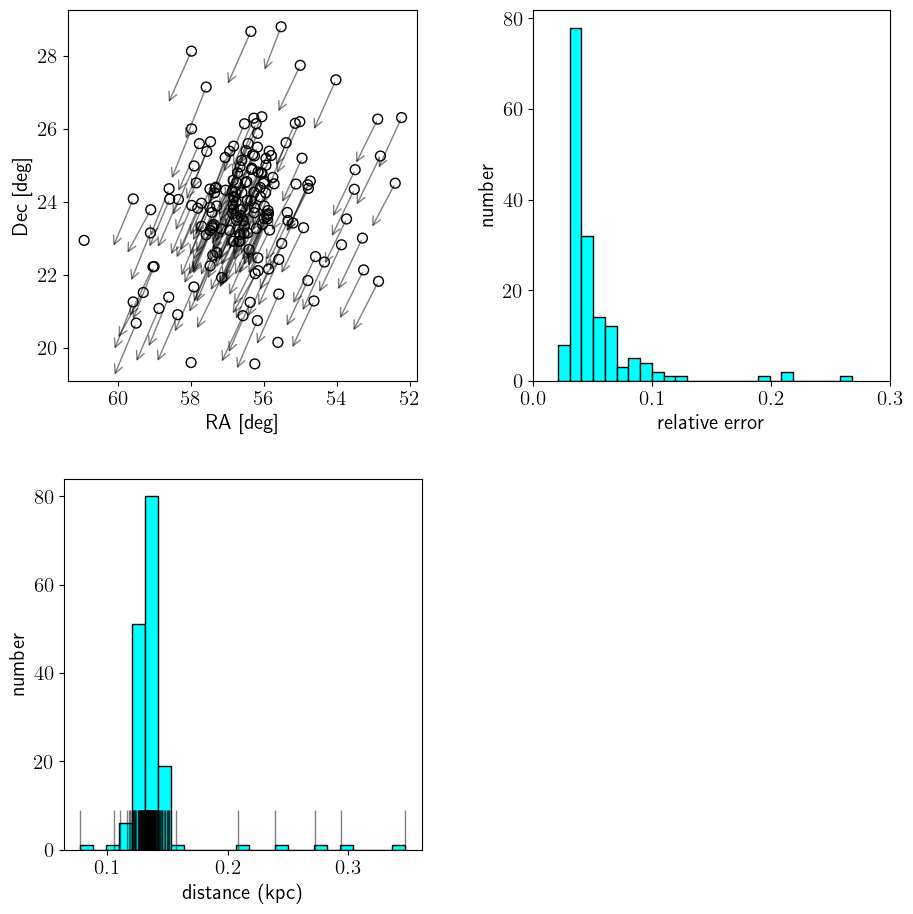

In [5]:
# Set font size
rcParams["font.size"] = 15
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Inspect the data
fig, ax = plt.subplots(2,2, figsize=(10,10))
# Set padding between subplots
fig.tight_layout(pad=3.0)
# Set arrow scale
sf = 0.03
# Plot the position with arrow of their motion
ax[0,0].scatter(data["ra"], data["dec"], s=50, facecolors='none', edgecolors='k')
for ra,de,pmra,pmde in zip(data["ra"], data["dec"], data["pmra"]*sf, data["pmdec"]*sf):
  arrow = ax[0,0].annotate("", xy=(ra+pmra, de+pmde), xytext=(ra, de),arrowprops=dict(arrowstyle="->", alpha=0.5))
  # arrow.set_alpha(.1)
ax[0,0].set_xlabel("RA [deg]")
ax[0,0].set_ylabel("Dec [deg]")
ax[0,0].invert_xaxis()
ax[0,0].set_aspect('equal')

# Plot relative error
ax[0,1].hist(data["parallax_error"]/data["parallax"], bins=25, edgecolor="k", color="aqua")
ax[0,1].set_xlim(0,0.3)
ax[0,1].set_xlabel("relative error")
ax[0,1].set_ylabel("number")

#Plot distance with rug
ax[1,0].hist(1/data["parallax"], bins=25, edgecolor="k", color="aqua")
ax[1,0].set_xlabel("distance (kpc)")
ax[1,0].set_ylabel("number")
ax[1,0].plot(1/data["parallax"], [1.0]*len(data["parallax"]), '|', color='k', ms=50, alpha=0.5)
# No need
ax[1,1].set_visible(False)

plt.show()

# Naive parallax combination

Based on [Bailer-Jones](https://github.com/ehalley/parallax-tutorial-2018/blob/master/Distance%20inference%20-%20multiple%20sources.ipynb) tutorial, the following methods are poor.

This methods use the mean of the inverse parallaxes (or 'distance'). This methods doesn't work if the parallax is negative, or has large relative error.

##### distance
$$
  r = \frac{1}{\varpi}
$$
##### standard deviation
$$
  \sigma_r = \text{std}\left (\frac{1}{\varpi} \right )
$$

In [6]:
rNaive0 = np.mean(1/data["parallax"])
rNaive0SD = np.std(1/data["parallax"])
print(f"Mean and SD of inverse parallaxes: {rNaive0:.7f} +/- {rNaive0SD:.7f} kpc")

Mean and SD of inverse parallaxes: 0.1376619 +/- 0.0267811 kpc


Don't asked me why, but according to the reference, the next better thing to do is by taking the inverse of mean parallaxes, and estimating its variance by a first order Taylor expansion.

##### distance
$$
  r_1 = \frac{1}{\bar{\varpi}}
$$
##### standard deviation
$$
  \sigma_{r_1} = \frac{1}{N\bar{\varpi}^{2}}\sqrt{\sum_{i}^{N}{\sigma_{\varpi,i}}}
$$

In [7]:
Nstar = len(data)
pMean = np.mean(data["parallax"])
rNaive1 = 1/pMean
rNaive1SD = 1/Nstar*np.sqrt(np.sum(data["parallax_error"]**2))/pMean
print(f"Inverse of mean parallaxes: {rNaive1:.7f} +/- {rNaive1SD:.7f} kpc")
spread = np.std(data["parallax_error"])/pMean**2
print(f"SD of inverse mean parallax in the sense of a spread: {spread:.7f} kpc")

Inverse of mean parallaxes: 0.1347596 +/- 0.0041475 kpc
SD of inverse mean parallax in the sense of a spread: 0.0028784 kpc


Even better, we can take a (variance) weighted mean. Specifically, take the inverse of the variance weighted mean of the parallaxes and estimate the variance of this again by a first order Taylor expansion.

##### distance
$$
  r_2 = \left(\frac{\sum_{i}\varpi_{i}/\sigma_{\varpi,i}^{2}}{\sum_{i}1/\sigma_{\varpi,i}^{2}}\right)^{-1}
$$
##### standard deviation
$$
  \sigma_{r_2} = \frac{r_2^{2}}{\sqrt{\sum_{i}1/\sigma_{\varpi,i}^{2}}}
$$

In [8]:
wfac = np.sum(1/data["parallax_error"]**2)
rNaive2 = wfac/(np.sum(data["parallax"]/data["parallax_error"]**2))
rNaive2SD = rNaive2**2/np.sqrt(wfac)
print(f"Inverse of weighted mean of parallaxes: {rNaive2:.07f} +/- {rNaive2SD:.07f} kpc")

Inverse of weighted mean of parallaxes: 0.1337066 +/- 0.0004282 kpc


# Estimate distance to cluster (no correlations or cluster spread)

We want to infer the distance of the cluster, $r$, given set of parallaxes $\{\varpi\}$ and the corresponding parallax errors $\{\sigma_{\varpi}\}$ of its members. In the meantime, let's assume the cluster is very small compared to its distance to us, such that we can consider the tru distance to all the stars to be the same value ("no spread"), equal to $r$. 
Then, its likelihood is multivariate $N$-dimensional Gaussian distributions.

\begin{alignat}{2}
P(r|\{\varpi\}, \{\sigma_{\varpi}\}) 
&\propto \ P(r) \ P(\{\varpi\} | r, \{\sigma_{\varpi}\}) \\
&\propto \ P(r) \ \prod_i P(\varpi_i | r, \sigma_{\varpi_i})
\end{alignat}

Let's compute and plot the posterior, using the exponentially decreasing space density prior with length scale rlen

In [10]:
# Prior scale length 1 kpc
rlen = 1
# sample distance, you can change the number of sampling
N = 1E5
r = np.linspace(0.13, 0.14, int(N))
# Calculate log prior
# why log? because the likelihood will be extremely small, we use natural logarithm
# to still be able to calculate it
log_prior = exponentiallyDecreasing.logpdf(r, scale=rlen)
# Calculate likelihood. In log, it becomes sum
log_likelihood = np.array([np.sum(norm.logpdf(1/rr, loc=data["parallax"], scale=data["parallax_error"])) for rr in r])
# Calculate log posterior. In log, it becomes sum
log_posterior = log_prior + log_likelihood

# Shift the log posterior, so that the number is not extremely small
max_posterior = np.max(log_posterior)
min_posterior = np.min(log_posterior)
print(f"max: {max_posterior}")
print(f"min: {min_posterior}")
mod_log_posterior = log_posterior - max_posterior

# Finally, calculate the unnormalized posterior, inverse log
mod_posterior = np.exp(mod_log_posterior)

# Find the normalization constant
normalization = integrate.simpson(mod_posterior, r)

# Calculate normalized posterior
norm_posterior = mod_posterior/normalization

# create interpolation posterior function, it will help later
posterior = interpolate.interp1d(r, norm_posterior, kind="cubic")

max: -545.7751605229608
min: -644.2179544852115


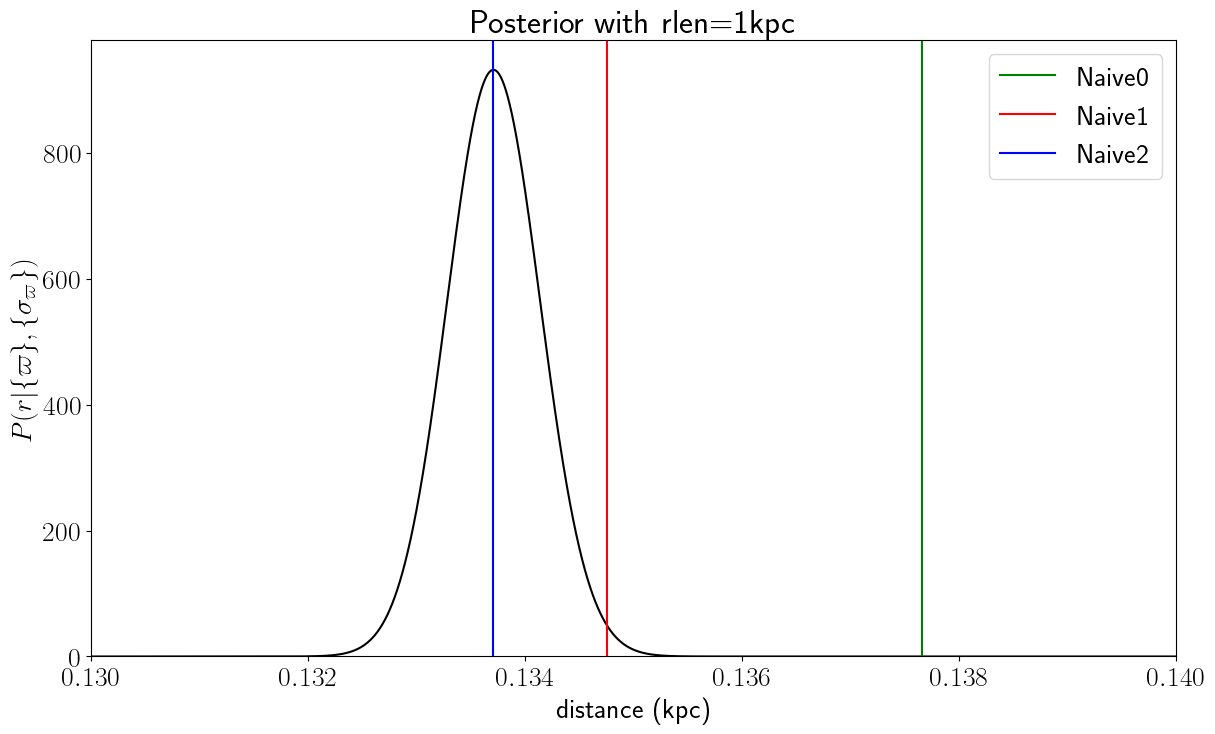

posterior = 0.1337091 +/- 0.0004272 kpc
Naive0 = 0.1376619 +/- 0.0267811 kpc
Naive1 = 0.1347596 +/- 0.0041475 kpc
Naive2 = 0.1337066 +/- 0.0004282 kpc


In [11]:
# Plot!
rcParams["font.size"] = 20
plt.figure(figsize=(14,8))
plt.plot(r, norm_posterior, c="k")
plt.ylim(0)
plt.xlim(min(r), max(r))
plt.axvline(rNaive0, c="g", label="Naive0")
plt.axvline(rNaive1, c="r", label="Naive1")
plt.axvline(rNaive2, c="b", label="Naive2")
plt.xlabel("distance (kpc)")
plt.ylabel(r"$P(r|\{\varpi\}, \{\sigma_{\varpi}\})$")
plt.title("Posterior with rlen=1kpc")
plt.legend()
plt.show()

# Find some statistics
mode = r[np.argmax(norm_posterior)]
hdi_perc = 0.68
hdi_below, hdi_upper = hdi(posterior, perc=hdi_perc, res=1E5, min=0.13, max=0.14)
print(f"posterior = {mode:.7f} +/- {(hdi_upper-mode):.7f} kpc")
print(f"Naive0 = {rNaive0:.7f} +/- {rNaive0SD:.7f} kpc")
print(f"Naive1 = {rNaive1:.7f} +/- {rNaive1SD:.7f} kpc")
print(f"Naive2 = {rNaive2:.07f} +/- {rNaive2SD:.07f} kpc")

# Estimate distance to cluster (with correlations, no cluster spread)
## Invent a simple model for spatial parallax correlations

Let consider correlation between parallaxes. 
Given a set of $N$ parallax measurements, their correlations are determined by the $N \times N$ covariance matrix. The likelihood for the $N$ measurements is no longer a product of $N$ one-dimensional Gaussian functions, but is rather an $N$-dimensional Gaussian

$
P({\boldsymbol \varpi} | {\mathbf r}, C) = \frac{1}{(2\pi)^{N/2}|C|^{1/2}}\exp\left[-\frac{1}{2}\left({\boldsymbol \varpi} - \frac{1}{{\mathbf r}}\right)^\mathsf{T} C^{-1} \left({\boldsymbol \varpi} - \frac{1}{{\mathbf r}}\right)\right]
$

where

$
\frac{1}{{\mathbf r}} = \left(\frac{1}{r_1}, \frac{1}{r_2}, \ldots \right) .
$

Following Bailer-Jones example, let's invent a model (unrelated to Gaia) which specifies that the correlation between any two parallax measurements, $\varpi_1$ and $\varpi_2$, is a function of the angular separation, $\theta$, of the two sources on the sky

$
\rho(\varpi_1, \varpi_2) = a\exp(-\theta/\theta_{\rm len})
$


where $\theta_{\rm len}>0$ is some fixed angular scale and $0\leq a \leq 1$ gives the amplitude of the correlation at zero separation. The elements of the covariance matrix $C$ are 

$
C_{i,j} = \rho(\varpi_i, \varpi_j)\sigma_{\varpi_i}\sigma_{\varpi_j}.
$

Provided the two sources are not widely separated and not near the poles, we can approximate their angular separation as simple cartesian Phytagoras

$
\theta = \left( [(\alpha_1\!-\!\alpha_2)\cos(0.5(\delta_1\!+\!\delta_2))]^2 + (\delta_1\!-\!\delta_2)^2  \right)^{1/2}
$

where $(\alpha, \delta)$ are the RA and declination of a source.

In the code that follows, the function parcor computes $\rho$, and parcovmat computes $C$.

In [12]:
# correlation function
def parcor(ra1, dec1, ra2, dec2, amp=0.5, thetaLen=0.5):
  sep = np.sqrt(((ra1-ra2)*np.cos(0.5*np.deg2rad(dec1+dec2)))**2+(dec1-dec2)**2)
  return amp*np.exp(-sep/thetaLen)

# Parallax covariant matrix
def parcovmat(data, amp, thetaLen):
  V = np.zeros((len(data), len(data)))
  for i in range(1, len(data)):
    for j in range(0, i):
      V[i,j] = (data["parallax_error"][i]*data["parallax_error"][j]*
                parcor(ra1=data["ra"][i], dec1=data["dec"][i],
                ra2=data["ra"][j], dec2=data["dec"][j], amp=amp, thetaLen=thetaLen))
      V[j,i] = V[i,j]
  return (V + np.diagflat(data["parallax_error"]**2))

# Set the amplitude
amp = 0.5
# set the angular scale in degrees
thetaLen = 0.5
# Covariant matrix
matrix = parcovmat(data, amp, thetaLen)

## Posterior distance estimate (with correlations)

In [13]:
# create list of distance sampling
r_cor = np.linspace(0.13, 0.14, 1000)
# calculate log likelihood
log_likelihood_cor = np.array([multivariate_normal.logpdf(1/rr, mean=data["parallax"], cov=matrix) for rr in r_cor])


In [15]:
# Pick prior scale length
rlen = 1 #kpc
# Caclulate log prior
log_prior_cor = exponentiallyDecreasing.logpdf(r_cor, scale=rlen)
# Calculate log posterior
log_posterior_cor = log_prior_cor + log_likelihood_cor
# find max min
max_posterior_cor = np.max(log_posterior_cor)
min_posterior_cor = np.min(log_posterior_cor)
print(f"max = {max_posterior_cor}")
print(f"min = {min_posterior_cor}")

# Shift the log posterior
mod_log_posterior_cor = log_posterior_cor - max_posterior_cor
# Calculate the unnormalized posterior
mod_posterior_cor = np.exp(mod_log_posterior_cor)
# Find the normalization constant
normalization_cor = integrate.simpson(mod_posterior_cor, r_cor)
# Calcultate the normalized posterior
norm_posterior_cor = mod_posterior_cor/normalization_cor
# create interpolation posterior function, it will help later
posterior_cor = interpolate.interp1d(r_cor, norm_posterior_cor, kind="cubic")

max = -654.2846163280126
min = -685.3832706896351


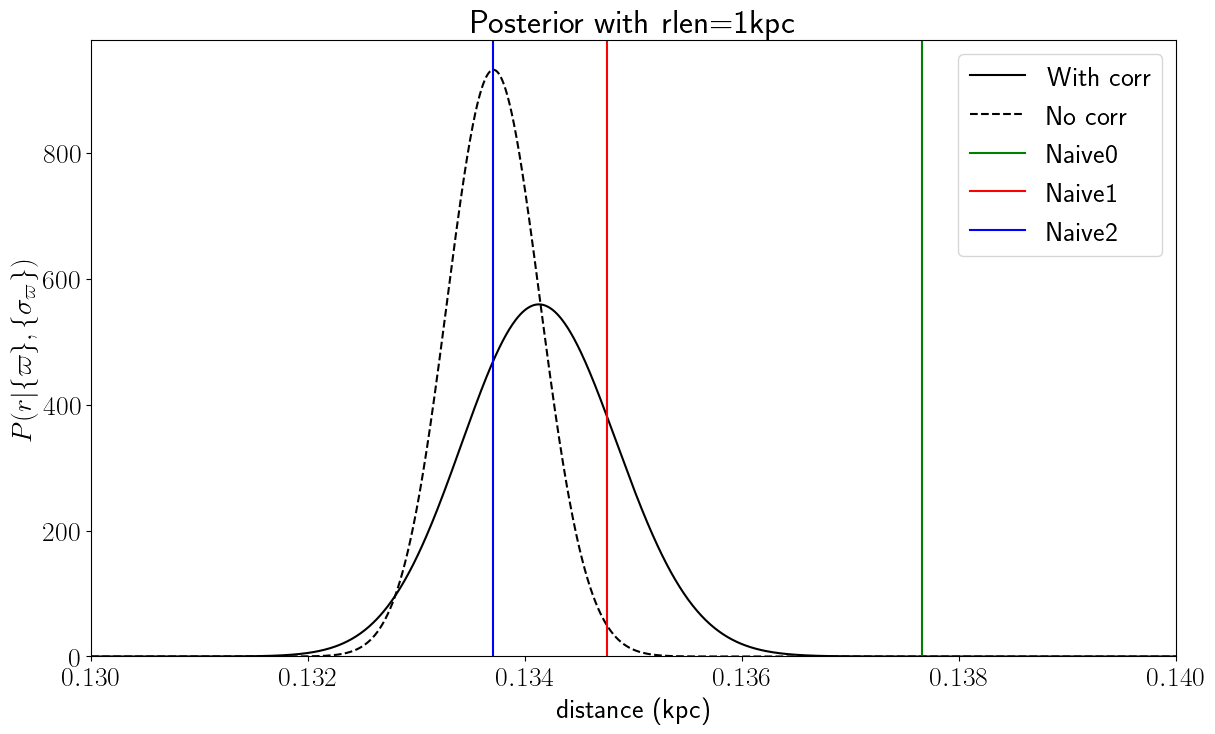

posterior no corr = 0.1337091 +/- 0.0004272 kpc
posterior with corr = 0.1341241 +/- 0.0007170 kpc
Naive0 = 0.1376619 +/- 0.0267811 kpc
Naive1 = 0.1347596 +/- 0.0041475 kpc
Naive2 = 0.1337066 +/- 0.0004282 kpc


In [20]:
# Plot
rcParams["font.size"] = 20
plt.figure(figsize=(14,8))
plt.plot(r_cor, norm_posterior_cor, c="k", label="With corr")
plt.plot(r, norm_posterior, c="k", label="No corr", ls="--")
plt.ylim(0)
plt.xlim(min(r), max(r))
plt.axvline(rNaive0, c="g", label="Naive0")
plt.axvline(rNaive1, c="r", label="Naive1")
plt.axvline(rNaive2, c="b", label="Naive2")
plt.xlabel("distance (kpc)")
plt.ylabel(r"$P(r|\{\varpi\}, \{\sigma_{\varpi}\})$")
plt.title("Posterior with rlen=1kpc")
plt.legend()
plt.show()

# some statistics
mode = r[np.argmax(norm_posterior)]
mode_cor = r_cor[np.argmax(norm_posterior_cor)]
hdi_perc = 0.68
hdi_below, hdi_upper = hdi(posterior, perc=hdi_perc, res=1E5, min=0.13, max=0.14)
hdi_below_cor, hdi_upper_cor = hdi(posterior_cor, perc=hdi_perc, res=1E5, min=0.13, max=0.14)

print(f"posterior no corr = {mode:.7f} +/- {(hdi_upper-mode):.7f} kpc")
print(f"posterior with corr = {mode_cor:.7f} +/- {(hdi_upper_cor-mode_cor):.7f} kpc")
print(f"Naive0 = {rNaive0:.7f} +/- {rNaive0SD:.7f} kpc")
print(f"Naive1 = {rNaive1:.7f} +/- {rNaive1SD:.7f} kpc")
print(f"Naive2 = {rNaive2:.07f} +/- {rNaive2SD:.07f} kpc")

# Estimate cluster distance and size (no correlations)

Assume tht the cluster has a finite size, such that the true (unknown) distances to the members cannot be assumed to be equal. We want to compute the posterior 

$P^*(r_c,s_c|\{\varpi\},\{\sigma_{\varpi}\})$

where $r_c$ and $s_c$ are cluster distance and size respectively. The cluster center in (RA, Dec) is assumed known. For the sake of illustration I assume the true stellar distances are drawn from a 3D isotropic Gaussian of mean rc and standard deviation sc.

As shown in the reference, the likelihood in the much more general case is a marginalization over the N unknown distances, i.e. an $N$-dimensional integral (equation 10)

$
P(\{\varpi\} | C, \{{\boldsymbol \alpha}\}, r_c, {\boldsymbol s}) = 
   \int P(\{\varpi\} | \{r\}, C) \, P(\{r\}| \{{\boldsymbol \alpha}\}, r_c, {\boldsymbol s})  \, d\{r\} 
$

where $P(\{\varpi\} | \{r\}, C)$ is the likelihood (multivariate Gaussian). The other term reflects the geometry of the cluster stars, which is given by equation 15. Here we neglect any correlations between the parallax measurements to reduce the likelihood to a product of $N$ one-dimensional integrals. In that case the likelihood can be written as given in equation 17. (Note that that equation does not yet assume the Gaussian or even isotropic model for the cluster.)

We can now proceed in three different ways to deal with the likelihood.
1. Nelgect the *angular* extent of the cluster, but not its finite depth. We can then assume that the true distances of the stars from the cluster center (z) are along the l.o.s, and thus drawn from a 1D Gaussian with mean 0 and stdev sc. This use the binomial approximation, and the binomial approximation is poor, so this is not demonstrated below.
2. As 1, but now using a numerical integration (Gaussian quadrature) of the likelihood (instead of the binomial approximation). This is given by equation 20 in the reference document.
3. Assume the cluster has a spherical Gaussian profile. For this we must specify the angular separations of the stars from the cluster centre, $\text{cos} \theta$. The integrals are done numerically (Gaussian quadrature). Sometimes the integrals don't converge (presumably due to limitations of the function "integrate"), so for those specific cases (given star and rc,sc values) I revert to case 2 (for which there is no justification other than that's robust).

Our model has two parameters, the cluster distance, rc, and cluster size, sc. We use separable priors. For rc again use the exponential decreasing space density prior. For sc let's use a gamma distribution (appropriate, because it is zero for negative sizes). Compute the posterior on a regular 2D grid.

## The cluster size dan distance prior

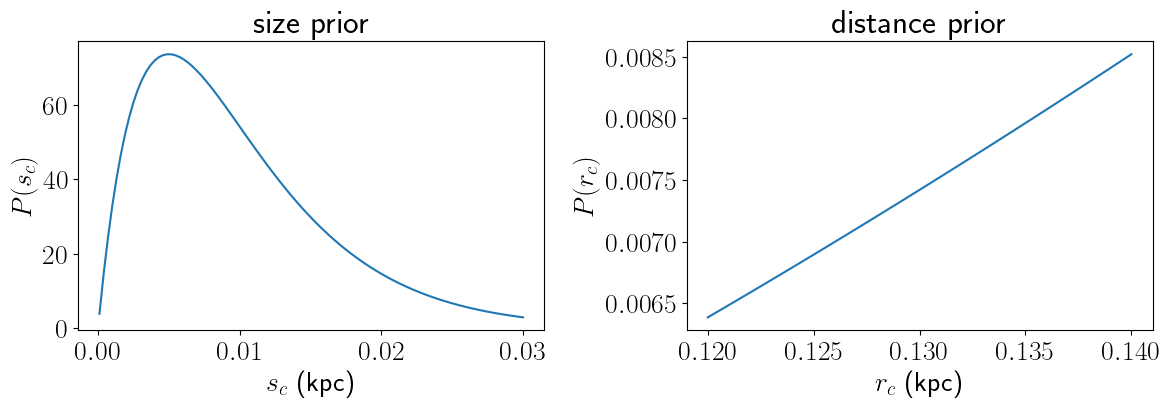

In [21]:
# Let's assume the prior of the size of the cluster follows gamma distribution
sc = np.linspace(0.0001, 0.03, 101)
scPriorShape = 2
scPriorScale = 0.005
sc_prior = gamma.pdf(sc, scPriorShape, scale=scPriorScale)
log_sc_prior = np.log(sc_prior)

# and the distance prior is exponentially decreasing constant denstiy
rc = np.linspace(0.12, 0.14, 100)
rlen = 1
rc_prior = exponentiallyDecreasing.pdf(rc, scale=rlen)
log_rc_prior = np.log(rc_prior)

# Plot hte prior
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
fig.tight_layout(pad=3.0)
ax1.plot(sc, sc_prior)
ax1.set_xlabel(r"$s_{c}$ (kpc)")
ax1.set_ylabel(r"$P(s_{c})$")
ax1.set_title("size prior")

ax2.set_xlabel(r"$r_{c}$ (kpc)")
ax2.set_ylabel(r"$P(r_{c})$")
ax2.set_title("distance prior")
ax2.plot(rc, rc_prior)

plt.show()

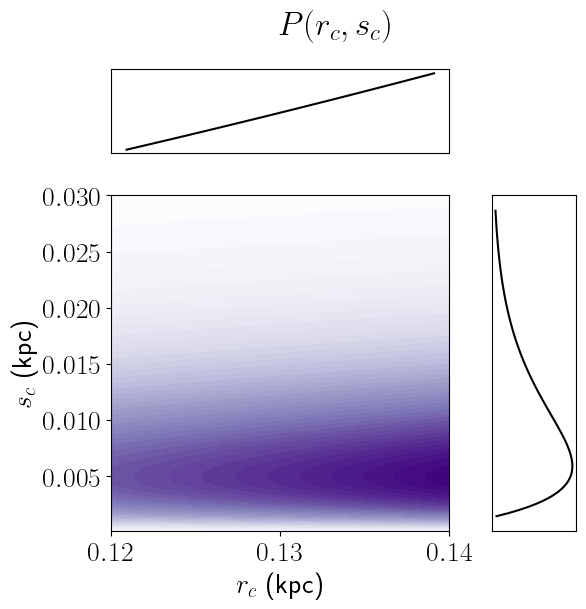

In [26]:
# Plot joint prior
X_prior, Y_prior = np.meshgrid(rc, sc)
pX, pY = np.meshgrid(rc_prior, sc_prior)
Z_prior = pX*pY

rcParams["font.size"] = 20
fig, ax = plt.subplots(2,2, figsize=(6,6), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4]})
ax[0,0].plot(rc, rc_prior, c="k")
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].get_yaxis().set_visible(False)
ax[1,0].contourf(X_prior, Y_prior, Z_prior, 50, cmap="Purples", origin="lower")
# ax[1,0].get_shared_x_axes().join(ax[0,0], ax[1,0])
ax[1,0].set_xlabel(r"$r_c$ (kpc)")
ax[1,0].set_ylabel(r"$s_c$ (kpc)")
# ax[1,1].get_shared_y_axes().join(ax[1,1], ax[1,0])
ax[1,1].plot(sc_prior, sc, c="k")
# ax[1,1].get_shared_x_axes().join(ax[0,0], ax[1,0])
ax[1,1].get_xaxis().set_visible(False)
ax[1,1].get_yaxis().set_visible(False)
ax[0,1].set_visible(False)
fig.suptitle(r"$P(r_{c}, s_{c})$")
plt.show()

## Compute posterior using case 2 (1D approximation of cluster geometry, numerical integrations)

The likelihood of this cluster can be approximated by

$$
  P(\{\varpi\}| \{\sigma_\varpi\}, r_c, s_c) \simeq \prod_{i=1}^{N}\int \frac{1}{\sqrt{2\pi}\sigma_{\varpi_{i}}}\exp\left[-\frac{\left(\varpi_{i}-1/r_{i}\right)^{2}}{2\sigma_{\varpi_{i}}^{2}} \right]\frac{1}{\sqrt{2\pi}s_{c}}\exp\left[-\frac{\left(r_{i}-r_{c}\right)^{2}}{2s_{c}^{2}} \right]\textup{d}r_{i}
$$

the full posterior becomes
$$
  P(r_{c}, s_{c}|\{\varpi\}, \{\sigma_\varpi\}) \propto P(\{\varpi\}| \{\sigma_\varpi\}, r_c, s_c) P(r_{c})P(s_{c})
$$

In [27]:
def integrand(r, p, p_error, rc, sc):
  return norm.pdf(p, loc=1/r, scale=p_error)*norm.pdf(r, loc=rc, scale=sc)

# This implementation is so slow, somehow, approx 12 minutes for 100x100 grid!
# use R to speed it up, only 2.5 minutes, so weird, heh?
log_likelihood_withsize = np.zeros((len(sc), len(rc)))
for i, r in enumerate(rc):
  for j, s in enumerate(sc):
    log_likelihood_withsize[j, i] = np.sum(np.log(
      integrate.quad_vec(lambda rr: integrand(rr, data["parallax"], data["parallax_error"], 
                                              rc=r, sc=s), 
                         a=np.max([0, r-5*s]), b=r+5*s)[0]))
  print(i, end=" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [28]:
# Calculate log posterior, as usual
log_posterior_withsize = np.zeros((len(sc), len(rc)))
for i, r in enumerate(rc):
  for j, s in enumerate(sc):
    log_posterior_withsize[j, i] = log_likelihood_withsize[j, i] + log_sc_prior[j] + log_rc_prior[i]

In [36]:
from scipy.interpolate import RectBivariateSpline
# shift
max_posterior_withsize = np.max(log_posterior_withsize)
mod_log_posterior_withsize = log_posterior_withsize - max_posterior_withsize
# Unnormalize posterior, with maximum of 1
posterior_withsize = np.exp(mod_log_posterior_withsize)

# Interpolation function of unnormalized, just be careful
# p_withsize = interpolate.interp2d(rc, sc, posterior_withsize, kind="cubic")
f = RectBivariateSpline(rc, sc, posterior_withsize.T)
rt = lambda xnew, ynew: f(xnew, ynew).T
p_withsize = rt(rc, sc)

Text(0, 0.5, '$s_{c}$ (kpc)')

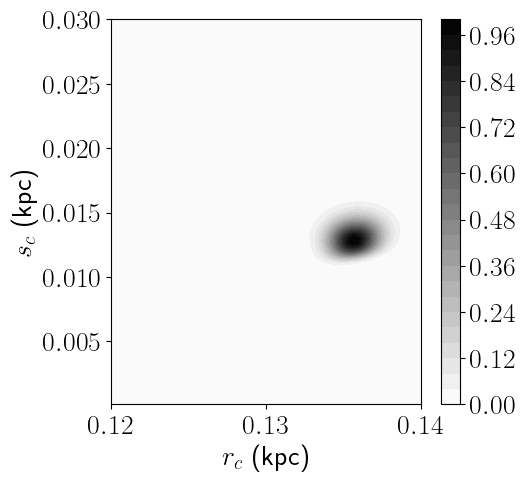

In [31]:
# plot!
X, Y = np.meshgrid(rc, sc)
plt.figure(figsize=(5,5))
plt.contourf(X, Y, posterior_withsize, levels=30, origin="lower", cmap="gist_yarg")
plt.colorbar()
plt.xlabel(r"$r_{c}$ (kpc)")
plt.ylabel(r"$s_{c}$ (kpc)")

In [40]:
rt(0.134, 0.011)[0][0]

np.float64(0.027213545922464735)

In [41]:
# Zoom on the black blob
SC, RC = np.linspace(0.0105, 0.0165, 1001), np.linspace(0.132, 0.139, 1000)
sC, rC = np.meshgrid(SC, RC)
Z = np.zeros_like(sC)
for i, s in enumerate(SC):
  for j, r in enumerate(RC):
    Z[j,i] = rt(r, s)[0][0]
  
maxZ = np.max(Z)
Z /= maxZ

Text(0, 0.5, '$s_{c}$ (kpc)')

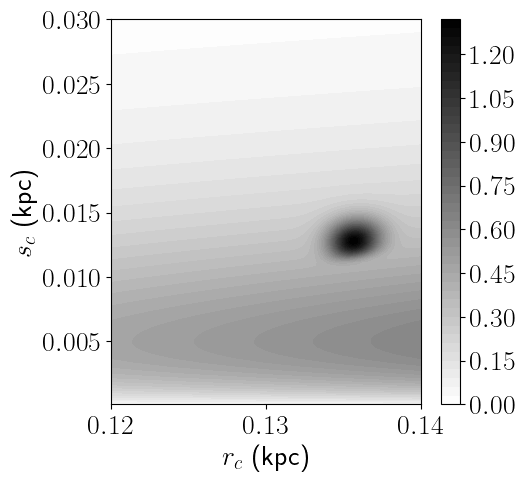

In [42]:
# Plot with prior!
plt.figure(figsize=(5,5))
plt.contourf(X, Y, posterior_withsize+Z_prior, levels=50, cmap="gist_yarg")
# plt.contourf(X_prior, Y_prior, Z_prior, 50, cmap="Purples", origin="lower", alpha=0.5)
plt.colorbar()
plt.xlabel(r"$r_{c}$ (kpc)")
plt.ylabel(r"$s_{c}$ (kpc)")

In [46]:
# Marginalize the posterior on sc and rc
pSC = integrate.simpson(Z, RC, axis=0)
normalization = integrate.simpson(pSC, SC)
pSC /= normalization
pRC = integrate.simpson(Z, SC, axis=1)
normalization = integrate.simpson(pRC, RC)
pRC /= normalization
# create interpolation function on marginalize sc and rc
prc = interpolate.interp1d(RC, pRC, kind="cubic")
psc = interpolate.interp1d(SC, pSC, kind="cubic")
# Statistics
modeSC = SC[np.argmax(pSC)]
modeRC = RC[np.argmax(pRC)]
hdi_perc = 0.68
hdi_below_sc, hdi_upper_sc = hdi(psc, perc=hdi_perc, res=1E5, min=SC[0], max=SC[-1])
hdi_below_rc, hdi_upper_rc = hdi(prc, perc=hdi_perc, res=1E5, min=RC[0], max=RC[-1])

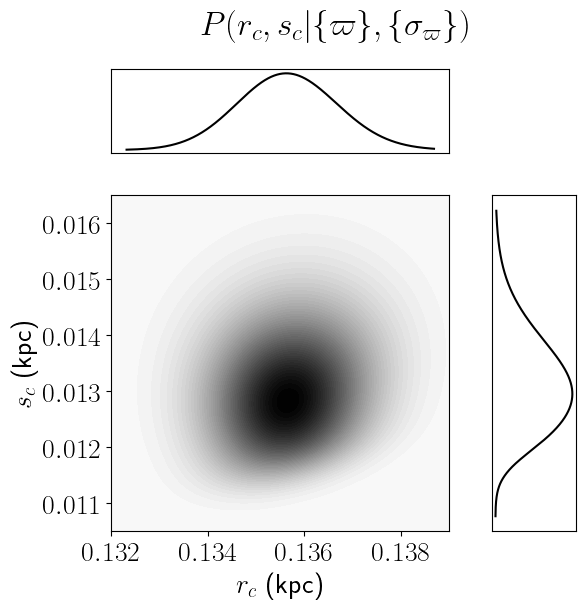

posterior sc = 0.01291 +0.00103/-0.00090 kpc
posterior rc = 0.13564 +0.00114/-0.00112 kpc


In [48]:
rcParams["font.size"] = 20
fig, ax = plt.subplots(2,2, figsize=(6,6), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4]})
ax[0,0].plot(RC, pRC, c="k")
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].get_yaxis().set_visible(False)
ax[1,0].contourf(rC, sC, Z, 50, cmap="gist_yarg", origin="lower")
# ax[1,0].get_shared_x_axes().join(ax[0,0], ax[1,0])
ax[1,0].set_xlabel(r"$r_c$ (kpc)")
ax[1,0].set_ylabel(r"$s_c$ (kpc)")
# ax[1,1].get_shared_y_axes().join(ax[1,1], ax[1,0])
ax[1,1].plot(pSC, SC, c="k")
# ax[1,1].get_shared_x_axes().join(ax[0,0], ax[1,0])
ax[1,1].get_xaxis().set_visible(False)
ax[1,1].get_yaxis().set_visible(False)
ax[0,1].set_visible(False)
fig.suptitle(r"$P(r_{c}, s_{c}|\{\varpi\}, \{\sigma_\varpi\})$")
plt.show()
print(f"posterior sc = {modeSC:.5f} +{(hdi_upper_sc-modeSC):.5f}/-{(modeSC-hdi_below_sc):.5f} kpc")
print(f"posterior rc = {modeRC:.5f} +{(hdi_upper_rc-modeRC):.5f}/-{(modeRC-hdi_below_rc):.5f} kpc")


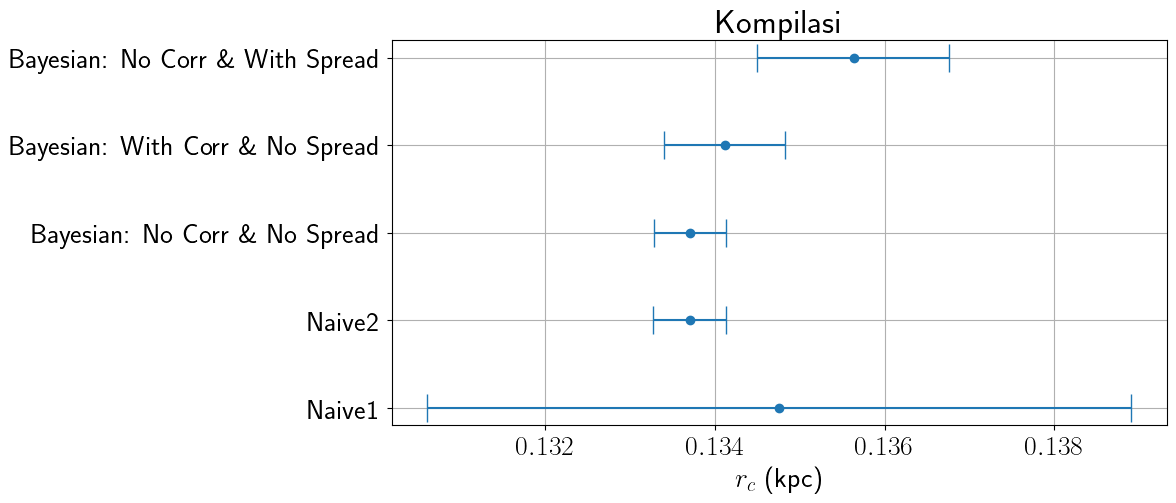

In [49]:
distance = np.array([rNaive0, rNaive1, rNaive2, mode, mode_cor, modeRC])
sigma_upper = [rNaive0SD, rNaive1SD, rNaive2SD, hdi_upper-mode, hdi_upper_cor-mode_cor, hdi_upper_rc-modeRC]
sigma_below = [rNaive0SD, rNaive1SD, rNaive2SD, mode-hdi_below, mode_cor-hdi_below_cor, modeRC-hdi_below_rc]
sigma = np.array([sigma_upper, sigma_below])
label = ["Naive0", "Naive1", "Naive2", "Bayesian: No Corr \& No Spread", "Bayesian: With Corr \& No Spread", "Bayesian: No Corr \& With Spread"]

plt.figure(figsize=(10,5))
plt.errorbar(distance[1:], label[1:], xerr=sigma[:,1:], fmt="o", capsize=10)
plt.grid()
plt.title("Kompilasi")
plt.xlabel(r"$r_c$ (kpc)")
plt.show()